In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import regex as re
from collections import Counter

import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk import chunk
from nltk.corpus import treebank_chunk

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
dfp1 = pd.read_csv('train.csv')
dfp1.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


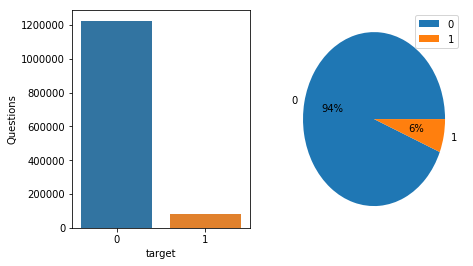

In [34]:
sr = dfp1['target'].value_counts()

plt.figure(figsize=(7,4))

plt.subplot(1,2,1)
sns.barplot(sr.index,sr.values)
plt.xlabel("target")
plt.ylabel("Questions")


plt.subplot(1,2,2)
plt.pie(sr.values,autopct='%.0f%%',labels=sr.index)
plt.legend()

plt.show()

<b>Observations:</b>
1. Data is very highly imbalanced
2. There are around 1.2M sincere Questions and only 80K insincere questions
3. Task at hand is inclined on finding insincere questions

In [25]:
dfp1.isna().sum()

qid              0
question_text    0
target           0
dtype: int64

<b>Observations:</b>
1. There are no missing data in any columns

In [27]:
dfp1.duplicated(['question_text']).sum()

0

<b>Observations:</b>
1. There are no duplicate questions

### Univariate & Bivariate Analysis

In [30]:
# function to calcluate top ngram features 
# input : target , ngrams
# output: top 50 tfidf features and their tfidf values

def tfidf_ftrs(trgt,ngrm):
    
    tfidfvctr = TfidfVectorizer(stop_words="english",ngram_range=(ngrm,ngrm))
    qtns_tfidf = tfidfvctr.fit_transform(dfp1[dfp1['target']==trgt]['question_text'])
    #print(cntvctr0.get_feature_names())
    #print("qtns_tfidf.shape:",qtns_tfidf.shape)

    qtns_tfidf_mn = np.array(np.mean(qtns_tfidf,axis=0))
    #print("qtns_tfidf_mn.shape:",qtns_tfidf_mn.shape)
    #print("qtns_tfidf_mn:",qtns_tfidf_mn)
    
    qtns_tfidf_idx = np.argsort(qtns_tfidf_mn[0])[::-1]
    #print("qtns_tfidf_idx:",qtns_tfidf_idx)
    
    qtns_tfidf_top50_ftrs = [tfidfvctr.get_feature_names()[i] for i in qtns_tfidf_idx[0:50]]    
    #print("qtns_tfidf_top50_ftrs:",qtns_tfidf_top50_ftrs)

    qtns_tfidf_mn_srt = np.sort(qtns_tfidf_mn)[0][::-1]
    #print("qtns_tfidf_mn_srt:",qtns_tfidf_mn_srt)
    #print("qtns_tfidf_mn_srt max:",max(qtns_tfidf_mn_srt))
    
    qtns_tfidf_top50 = qtns_tfidf_mn_srt[0:50]
    #print("qtns_tfidf_top50:",qtns_tfidf_top50)
    
    return qtns_tfidf_top50,qtns_tfidf_top50_ftrs

In [31]:
# top 50 unigram features #

qtn0_tfidf_top50 , qtn0_tfidf_top50_ftrs = tfidf_ftrs(0,1)
#print("qtn0_tfidf_top50:",qtn0_tfidf_top50)
print("qtn0_tfidf_top50_ftrs:",qtn0_tfidf_top50_ftrs)

print("-----------------------------------------------------")

qtn1_tfidf_top50 , qtn1_tfidf_top50_ftrs = tfidf_ftrs(1,1)
#print("qtn1_tfidf_top50:",qtn1_tfidf_top50)
print("qtn1_tfidf_top50_ftrs:",qtn1_tfidf_top50_ftrs)


qtn0_tfidf_top50_ftrs: ['does', 'best', 'people', 'like', 'good', 'did', 'india', 'make', 'life', 'time', 'think', 'way', 'know', 'use', 'work', 'person', 'world', 'want', 'feel', 'quora', 'job', 'better', 'year', 'start', 'mean', 'don', 'possible', 'learn', 'money', 'new', 'love', 'difference', 'used', 'need', 'business', 'school', 'years', 'things', 'different', 'engineering', 'college', 'just', 'online', 'long', 'country', 'indian', 'really', 'day', 'thing', 'old']
-----------------------------------------------------
qtn1_tfidf_top50_ftrs: ['people', 'women', 'trump', 'like', 'does', 'men', 'white', 'muslims', 'think', 'did', 'don', 'quora', 'sex', 'indian', 'black', 'india', 'americans', 'girls', 'hate', 'indians', 'just', 'want', 'world', 'liberals', 'chinese', 'muslim', 'country', 'gay', 'american', 'make', 'donald', 'jews', 'america', 'feel', 'president', 'good', 'true', 'really', 'racist', 'believe', 'know', 'questions', 'say', 'man', 'countries', 'god', 'woman', 'stupid', 'ol

In [32]:
# top 50 bigram features #

qtn0_tfidf_top50_bigrm , qtn0_tfidf_top50_ftrs_bigrm = tfidf_ftrs(0,2)
#print("qtn0_tfidf_top50_bigrm:",qtn0_tfidf_top50_bigrm)
print("qtn0_tfidf_top50_ftrs_bigrm:",qtn0_tfidf_top50_ftrs_bigrm)
print("---------------------------------------------------------------------------")
qtn1_tfidf_top50_bigrm , qtn1_tfidf_top50_ftrs_bigrm = tfidf_ftrs(1,2)
#print("qtn1_tfidf_top50_bigrm:",qtn1_tfidf_top50_bigrm)
print("qtn1_tfidf_top50_ftrs_bigrm:",qtn1_tfidf_top50_ftrs_bigrm)

qtn0_tfidf_top50_ftrs_bigrm: ['best way', 'does mean', 'year old', 'united states', 'look like', 'high school', 'computer science', 'feel like', 'donald trump', 'social media', 'long does', 'major accomplishments', 'make money', 'best ways', 'does feel', 'north korea', 'jee mains', 'years old', 'different types', 'good bad', 'best place', 'pros cons', 'people think', 'best friend', 'machine learning', 'don know', 'best book', 'real life', 'mechanical engineering', 'don want', 'new york', 'useful tips', 'earn money', 'best books', 'real estate', 'long term', 'people like', 'tips starting', 'world war', 'civil engineering', 'class 12', 'starting work', 'digital marketing', 'tv series', 'win fight', 'good idea', 'programming language', 'best thing', 'star wars', 'harry potter']
---------------------------------------------------------------------------
qtn1_tfidf_top50_ftrs_bigrm: ['donald trump', 'black people', 'white people', 'year old', 'united states', 'president trump', 'trump suppo

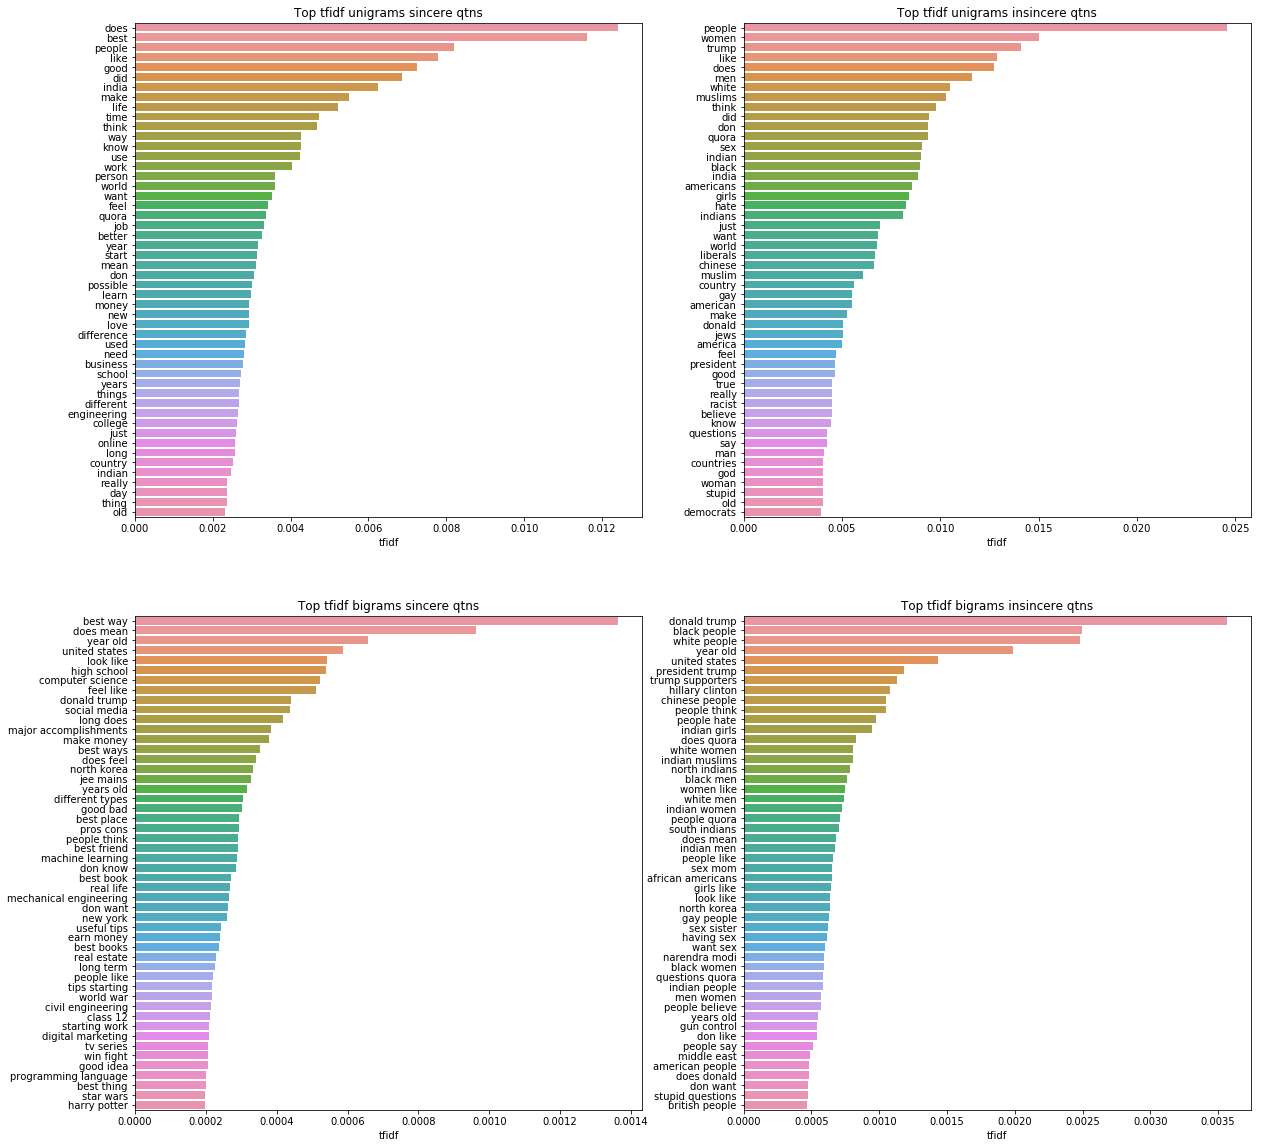

In [33]:
plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
sns.barplot(x=qtn0_tfidf_top50,y=qtn0_tfidf_top50_ftrs)
plt.xlabel("tfidf")
plt.title("Top tfidf unigrams sincere qtns")

plt.subplot(2,2,2)
sns.barplot(x=qtn1_tfidf_top50,y=qtn1_tfidf_top50_ftrs)
plt.xlabel("tfidf")
plt.title("Top tfidf unigrams insincere qtns")

plt.subplot(2,2,3)
sns.barplot(x=qtn0_tfidf_top50_bigrm,y=qtn0_tfidf_top50_ftrs_bigrm)
plt.xlabel("tfidf")
plt.title("Top tfidf bigrams sincere qtns")

plt.subplot(2,2,4)
sns.barplot(x=qtn1_tfidf_top50_bigrm,y=qtn1_tfidf_top50_ftrs_bigrm)
plt.xlabel("tfidf")
plt.title("Top tfidf bigrams insincere qtns")

plt.show()

<b>Observations:</b>
1. Top features in sincere questions mostly relate to Tech,Engineering,Science,likes etc
2. Top features in insincere questions relate to race,religion,particular person(s),countries etc
3. There are some common features in sincere and insincere questions like cities,person etc
4. Bigrams have less common features compared to unigrams
5. Bigrams features seems to be more in completeness and meaning campared to unigrams 